# **Using M3d-CAM for classification**

In this demo you will learn how to use M3d-CAM for classification using a resnet152. We will use a subset of the famous [Cats vs Dogs Dataset](https://github.com/Karol-G/gcam_cat_dog_examples) for this demo. \\

This demonstration was made using Google Colab and probably won't work if you are not using Colab.

# Preparation

Clone the Cats vs Dogs repository and set up the data structure:

In [1]:
!git clone https://github.com/Karol-G/Gcam_cat_dog_examples.git

Cloning into 'Gcam_cat_dog_examples'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 3), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 485.66 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Install M3d-CAM:

In [ ]:
pip install medcam

# Model & dataloader setup

Next we set up our resnet152 model and the dataloader for loading the cat and dog images:

In [6]:
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import cv2

# Setup the model
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = models.resnet152(pretrained=True)
model.to(device=device)
model.eval()

def load_image(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    image = image.to(device)
    return image

# Load the dataset
dataset = ImageFolder('./Gcam_cat_dog_examples/dataset', loader=load_image)
# Set up the dataloader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Injecting M3d-CAM into resnet152

The beauty of M3d-CAM is that you only need to insert a single line of code (or two if you count the import) for everything to work:

In [7]:
from medcam import medcam

model = medcam.inject(model, output_dir='attention_maps', backend='gcam', layer='layer4', label='best', save_maps=True)

After your model is injected with M3d-CAM it will still behave as it would normally do. So even if you have a big and complex project nothing will break and it will run as it always did. \\
The only difference is that every time the `model.forward()` of your model is called attention maps will be generated for your current input and automatically saved to `output_dir`. \\
The output of your model stays the same as before the injection. (Of course you can change this behavior and return the attention maps instead by setting `replace=True` during the injection).

Now to generate some attention maps we will call the `model.forward()` with the cat and dog images a couple times:

In [8]:
batch = next(iter(data_loader))
_ = model(batch[0])

Now you can display the generated attention maps in colab with:

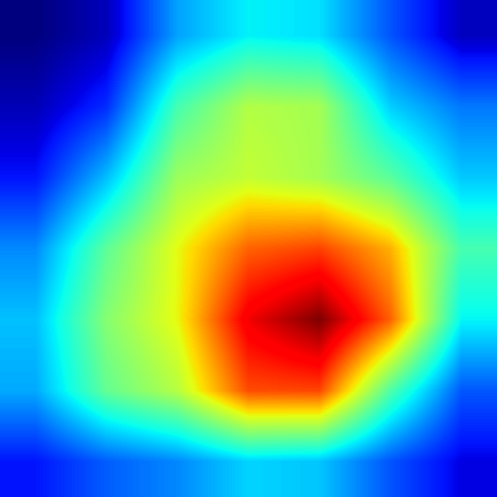

In [9]:
from IPython.display import Image

Image('./attention_maps/layer4/attention_map_0_0_0.png')

# Some further notes

As M3d-CAM offers multiple methods of visualization (*backends*) you can simply change the backend keyword to one of the following: \\
- *gbp* (Guided Backpropagation)
- *gcam* (Grad-Cam, default)
- *ggcam* (Guided Grad-Cam)
- *gcampp* (Grad-Cam++)

The layer keyword tells M3d-CAM for which layer the attention maps should be generated. You can also set the layer to 'auto' (the default setting) and M3d-CAM will choose the last convolutional layer which is what you want in most cases. However this is still experimental and won't always choose the correct layer. But it works in most cases. \\
You can print all layers of a model with `medcam.get_layers(model)` if you don't know the layer names. However you cannot generate attention maps from every layer. \\

Furthermore the label keyword tells M3d-CAM on which class label it should focus. The default setting is 'best' which always selects the class with the highest probability. Alternativly you can set the label manually as a number.